# RA Diagnosis Extraction with Machine Learning
This notebook is built for extracting the diagnosis from format-free textfields of Electronic Medical Health records. 
- Feel free to make some adjustments that best correspond to your data

In [13]:
SEED = 26062019

test_size = 0.5 

import sys
sys.path.append('src/')
import scipy
from yellowbrick import __version__ as yb_vers
from sklearn import __version__ as sk_vers
import NLP_functions as func
from pattern import __version__ as pat_vers
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
from matplotlib import __version__ as m_vers
import re
import random
import pickle
import seaborn as sns
from nltk import __version__ as nlv
from ipykernel import __version__ as ipyver
import pyxdameraulevenshtein as pyx # can be used for typo detection

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)
print('scipy version:\t\t' + scipy.__version__)
print('pattern version:\t' + pat_vers)
print('nltk version:\t\t' + nlv)
print('yellowbrick version:\t' + yb_vers)
print('seaborn version:\t' + sns.__version__)
print('pickle version:\t\t' + pickle.format_version)
print('ipykernel version:\t' + ipyver)


Current versions Modules:

Pandas version:		1.1.4
Matplotlib version:	3.3.1
numpy version:		1.19.5
sklearn version:	1.0.2
scipy version:		1.4.1
pattern version:	3.6
nltk version:		3.5
yellowbrick version:	1.3.post1
seaborn version:	0.11.0
pickle version:		4.0
ipykernel version:	5.3.4


## Step 1: Cleaning Data with NLP methods
To clean our sample data we will apply the following Natural Language Processing algorithms:
- Converting the entry based dataset to an patient based dataset
- Word segmentation: words are split on whitespace -> special characters are removed
- lemmatization: words are returned to the root form (if word is in corpus) - default= Dutch (nl)
- Typocorrection
- XML artefact removal

These function can be useful, depending on the quality of the data

### 1.1 Open raw file
Our sample table consists of three columns split by semicolon (';'). We have the following columns: 
- PATNR= patient id
- text= free text field from the EMR (Conclusion)
- annotation = associated label:
    - 'True' = RA-case
    - 'False' = not an RA-case

In [3]:
radiag_df = pd.read_csv(r'sample_data/dummydata.csv', sep=';')
print('nr of entries: ', len(radiag_df))
radiag_df.head()

nr of entries:  2000


,PATNR,annotation,text
0,474.0,False,normocytair anemie geen hemoly antistof anf en...
1,2.0,True,suppletie polyartritis ikv rf en anti ccp posi...
2,423.0,False,bij ncm functiebeperking li hand niet verklare...
3,40.0,True,met seropositief erosief destructief ra waarvo...
4,286.0,True,klinisch voor anderen systeemziekte sl sclerod...


### 1.2 Merge on patient id
Compress the free-text fields per patient

In [4]:
id_column='PATNR'
X_column='text'
y_column="annotation"

print('[BEFORE] nr of entries:', len(radiag_df), '\tnr of patients:', len(radiag_df['PATNR'].unique()))
radiag_df = func.mergeOnColumn(radiag_df, id_column, X_column, y_column)
print('[AFTER] nr of entries:', len(radiag_df), '\tnr of patients:', len(radiag_df['PATNR'].unique()))

[BEFORE] nr of entries: 2000 	nr of patients: 668
[AFTER] nr of entries: 668 	nr of patients: 668


### 1.3 Renaming columns & labels

1. We will change the column names 'annotation' to 'Outcome' and 'text' to 'Text'. From now on we can only refer to the adjusted column names.
2. Furthermore, we will apply a different standard for the label data (TRUE -> y and FALSE -> n)

In [5]:
radiag_df = radiag_df.rename(columns={y_column: "Outcome", X_column: "Text"})
radiag_df['Outcome'] = radiag_df['Outcome'].apply(lambda x: 'y' if x == True else 'n')
radiag_df[['Text', 'Outcome']].head()

,Text,Outcome
0,normocytair anemie geen hemoly antistof anf e...,n
1,suppletie polyartritis ikv rf en anti ccp pos...,y
2,bij ncm functiebeperking li hand niet verklar...,n
3,met seropositief erosief destructief ra waarv...,y
4,klinisch voor anderen systeemziekte sl sclero...,y


### 1.4 Preprocessing - Word segmentation  ( + Typo correction)
FYI: 1. The typo correction step is currently muted on purpose, because this step only applies if you're working with Dutch data + the python implementation is quite slow (so you might prefer to screen for typos with another tool). 

In [6]:
radiag_df['Text'] = radiag_df['Text'].apply(lambda x : func.processArtefactsXML(str(x)))
radiag_df['Text'] = radiag_df['Text'].apply(lambda x : func.simpleCleaning(x, lemma=False))

# Apply TypoCorrection  
  #  import time
  #  typocor = func.TypoCorrection(np.array(l_new)) # provide word list
  #  t0 = time.time()
  #  radiag_df['Text'] = radiag_df['Text'].apply(lambda x : typocor.correct(x))
  #  t1 = time.time()
  #  print('Time for TypoCorrection (n=' + str(len(radiag_df)) + ') : ' + str(t1-t0))

### 1.5 Preprocessing - Stemming or lemmatization
We normalize the words back to the 'root' form (removing the varying inflections). This ensures that semantically similar features are treated the same. With this approach we effectively reduce the number of dimensions

##### Import NLTK stemmer
As you can see NLTK supports a myriad of languages

In [17]:
#!pip install -U nltk 
#from nltk.stem.snowball import SnowballStemmer 
#stemmer = SnowballStemmer("dutch") # Dutch 
#stemmer = SnowballStemmer("arabic") # Arabic 
#stemmer = SnowballStemmer("danish") # Danish
#stemmer = SnowballStemmer("english") # English 
#stemmer = SnowballStemmer("finnish") # Finnish
#stemmer = SnowballStemmer("french") # French
#stemmer = SnowballStemmer("german") # German 
#stemmer = SnowballStemmer("hungarian") # Hungarian 
#stemmer = SnowballStemmer("italian") # Italian 
#stemmer = SnowballStemmer("norwegian") # Norwegian 
#stemmer = SnowballStemmer("portuguese") # Portuguese 
#stemmer = SnowballStemmer("romanian") # Romanian 
#stemmer = SnowballStemmer("russian") # Russian 
#stemmer = SnowballStemmer("spanish") # Spanish 
#stemmer = SnowballStemmer("swedish") # Swedish 

##### Import custom stemmer for other languages (another example)

In [ ]:
#!pip install -U greek-stemmer # Greek
#from greek_stemmer import GreekStemmer
#stemmer = GreekStemmer() # Dutch 

#### #1.5.1 Perform stemming (Example in Dutch)

In [ ]:
#!pip install -U nltk 
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("dutch") # Dutch 

In [16]:
radiag_df['Text'] = radiag_df['Text'].apply(lambda x : func.stemmingText(x, stemmer=stemmer))
radiag_df=radiag_df.fillna('')

# Save autocorrected dataframe
radiag_df.to_csv(r'sample_data/autocorrect_dummydata.csv', sep='|', index=False)

,Text,PATNR,Outcome
0,normocytair anemie gen hemoly antistof anf en...,474.0,n
1,suppletie polyartritis ikv rf en anti ccp pos...,2.0,y
2,bij ncm functiebeperk li hand niet verklar do...,423.0,n
3,met seropositief erosief destructief ra waarv...,40.0,y
4,klinisch vor ander systeemziekt sl scleroderm...,286.0,y
...,...,...,...
663,artralgie hand voet vnl na gebruik dd toch oa...,334.0,y
664,weinig mogelijk medicatie gat stop met oac ac...,515.0,n
665,beschouw als ongedifferentieerd artritis dd s...,0.0,y
666,nieuw ontstanen koortsperiod met dyspnoe dysp...,605.0,n


## Step 2: Structuring the data

### 2.1 Open the preprocessed file
You can skip the above steps if you already have a preprocessed file

In [15]:
radiag_df = pd.read_csv(r'sample_data/autocorrect_dummydata.csv', sep='|')
radiag_df=radiag_df.fillna('')
radiag_df[['Text', 'Outcome']].head()

,Text,Outcome
0,normocytair anemie gen hemoly antistof anf en...,n
1,suppletie polyartritis ikv rf en anti ccp pos...,y
2,bij ncm functiebeperk li hand niet verklar do...,n
3,met seropositief erosief destructief ra waarv...,y
4,klinisch vor ander systeemziekt sl scleroderm...,y


### 2.2 Balancing classes in data (Proportion RA cases vs. non cases) - Optional
The number of non-cases is larger than nr. of cases so a random sample of non cases is selected to create a balance between the classes. 
- Optional: Whether or not you want to balance the classes depends on the expected prevalence of the cases in the test data. 
- You could also choose to balance the classes in a different way (eg: 1:5) but it should always correspond with the expected prevalence in the test set. Choose the desired nr of samples by changing nr_of_samples

FYI: the data is not balanced by default 

In [10]:
balance = False
nr_of_samples = len(radiag_df[radiag_df['Outcome']=='y'])

if (balance):
    df_no_outcome = radiag_df[radiag_df['Outcome']=='n'].sample(n=nr_of_samples, random_state=SEED)
    equal_radiag_df = pd.concat([df_no_outcome, radiag_df[radiag_df['Outcome']=='y']])
    radiag_df = equal_radiag_df.sample(frac=1, random_state=SEED)

### 2.3 Remove stop words

In [11]:
from nltk.corpus import stopwords

stop_words = stopwords.words('dutch')
radiag_df['Text'] = radiag_df['Text'].apply(lambda x: ' '.join([item for item in x.split(' ') if item not in stop_words]))

### 2.4 Splitting annotated set on both the textual data and the corresponding label (Y)

In [12]:
radiag_df = radiag_df.sample(frac=1, random_state=SEED) # random shuffle

X = radiag_df['Text'].values
y = radiag_df['Outcome'].values
y_b = np.array([func.binarize(val) for val in y])

### 2.5 Visualizing the data
#### Plot: Prevalence of RA-cases
Positive control -> classes should be in balance

(336, 332)


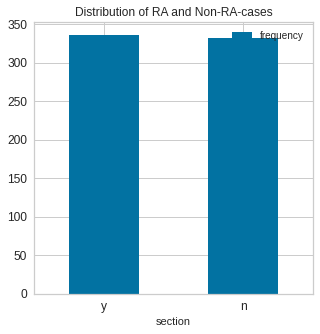

In [13]:
from collections import Counter

labels, values = zip(*Counter(y).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of RA and Non-RA-cases", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

#### Plot: Lexical Dispersion Plot
- Showcases the prevalence of features
- The feature’s homogeneity across the entries

src/NLP_functions.py:573: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  d = np.array(words)
/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
<ipython-input-14-4f591371587c>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  func.plotLexicalDispersion(X, nr_features=20, ngram_range=(1,1))
*c* argument looks like a single numeric RGB or RGBA 

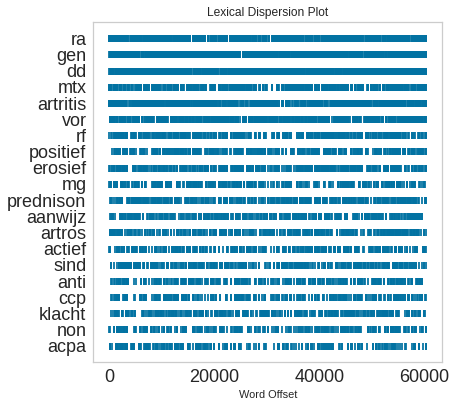

In [14]:
func.plotLexicalDispersion(X, nr_features=20, ngram_range=(1,1))

#### Plot: Feature distribution

<module 'matplotlib.pyplot' from '/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/matplotlib/pyplot.py'>

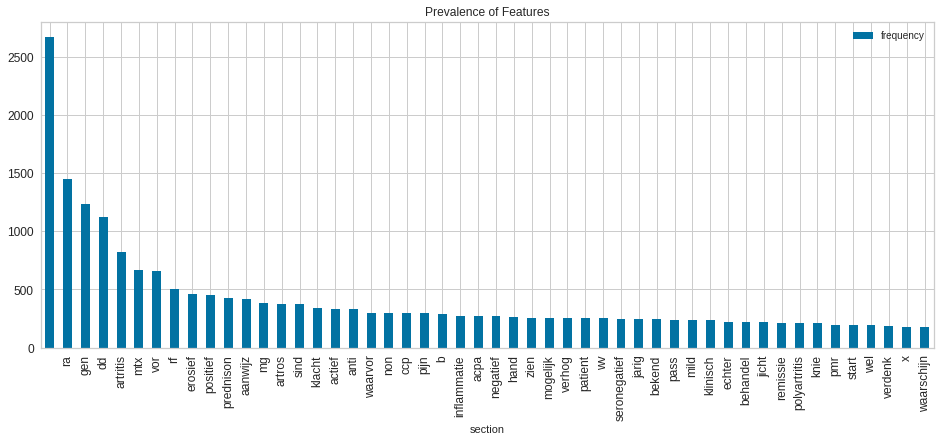

In [15]:
func.plotSampleDistribution(X, nr_features=50) 

## Step 3: Building the Pipeline & Fitting models
import all of the classifiers that you want to apply/compare

### 3.1 Import different classification models:
Listed below are the following models: Naive Bayes, Gradient Boosting, Neural Networks, Decision tree & SVM.

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier

### 3.2 Initialize the different models

#### Word Matching
The word matching method classifies based on the presence of the provided targets.

The following targets are provided: 'rheumatoid arthritis', 'reumatoide artritis' and 'ra' (Dutch)

In [18]:
import TextClassification as tc

l_targets = ['rheumatoid arthritis', 'reumatoide artritis', 'ra']

WordMatching = tc.CustomBinaryModel(l_targets)

#### Initialize classifiers
All methods except for the naive word matching method require vectorized data. Hence, the classifiers are accompanied with a TfidfVectorizer function 

In [19]:
SEED=26062019
models = [
    # 0
    WordMatching,
    # Naive Bayes - 1
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3), stop_words = stop_words)),
                ('clf', MultinomialNB()),
            ]),
    # Gradient Boosting - 2
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3), stop_words = stop_words)),
                ('clf', ske.GradientBoostingClassifier(random_state=SEED))
            ]),
    # Neural Networks - 3
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3), stop_words = stop_words)),
                ('clf', MLPClassifier(solver='lbfgs', random_state=SEED)), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Decision Tree - 4
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3), stop_words = stop_words)),
                ('clf', tree.DecisionTreeClassifier(random_state=SEED)),
            ]),
    # SVM 5
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3), stop_words = stop_words)),
                ('clf', SVC(kernel='linear', probability=True, random_state=SEED)),
            ]),
    # Random Forest 6
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3), stop_words = stop_words)),
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    # Dummy 7
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3), stop_words = stop_words)),
                ('clf', DummyClassifier(random_state=SEED, strategy='stratified')),
            ]),
    ]

#### Naming the models
1. Provide each of your methods with a relevant or recognizable name -> by providing a list.
2. You could also assign the preffered color palette!

Be careful: keep the same order as above

In [20]:
names = ['Word Matching', 'Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'Decision Tree', 'SVM', 'Random Forest', 'Dummy']
pal = ['r', 'c', 'b', 'g', 'y', 'magenta', 'indigo', 'black', 'orange'] 

### 3.3: Fitting the classifiers

The models can now be applied on the trainingsdata.

#### 3.3.1 Set parameters
Consider adjusting the default parameters to your liking:

- seed : pseudo random number generator, to ensure replication 
- pathway : pathway to preferred directory
- binarize label -> label will be changed to either 0 or 1, so you should mention how the true labels are encoded (default=y)
- palette : list of colorcodes  
Furthermore the function assignPalette() is applied : automatically assigns a classifier to a color, to ensure the same color over multiple plots



In [22]:
import TextClassification as tc

tm = tc.TextClassification(X, y, models, names)

tm.setSeed(26062019)
tm.setOutputPath(r'output_files/')
tm.binarizeLabel(y, true_label='y')
tm.assignPalette()

{'Word Matching': 'r', 'Naive Bayes': 'y', 'Gradient Boosting': 'c', 'Neural Networks': 'b', 'Decision Tree': 'g', 'SVM': 'magenta', 'Random Forest': 'indigo', 'Dummy': 'black'}


#### 3.3.2 Choose cross validation procedure
To ensure a robust performance evaluation you are advised to calculate the performance over multiple folds and/or rounds. We have provided two commonly used procedures down below:

###### When to use 10 CV?

If you want to have a reliable approximate of the classifier's performance on unseen data
###### When to use 5x2 CV?

If you want to compare the classifiers fairly

In [23]:
approach = '5x2CV'

if approach == '10CV':
    tm.setRounds(1)
    tm.setFolds(10)
elif approach == '5x2CV':
    tm.setRounds(5)
    tm.setFolds(2)

tm.fitModels()


General settings for training/testing:
Method = Cross Validation 10-fold
	fraction test:	 0.5 

loading model:  Word Matching
Word Matching is assumed to be a word matching method and is therefore not fitted
loading model:  Naive Bayes
loading model:  Gradient Boosting
loading model:  Neural Networks
loading model:  Decision Tree
loading model:  SVM
loading model:  Random Forest
loading model:  Dummy


## Step 4 : Evaluate model selection

### 4.1 ROC-AUC
Visualize performance of the models in ROC curve

Word Matching 0.8250898522653688 (std : +/-0.01 )
Naive Bayes 0.95270314547493 (std : +/-0.01 )
Gradient Boosting 0.9111147863850068 (std : +/-0.01 )
Neural Networks 0.9502552530902785 (std : +/-0.01 )
Decision Tree 0.7682277542855865 (std : +/-0.02 )
SVM 0.9536426717743117 (std : +/-0.01 )
Random Forest 0.9420791878024389 (std : +/-0.01 )
Dummy 0.4962128547576413 (std : +/-0.03 )


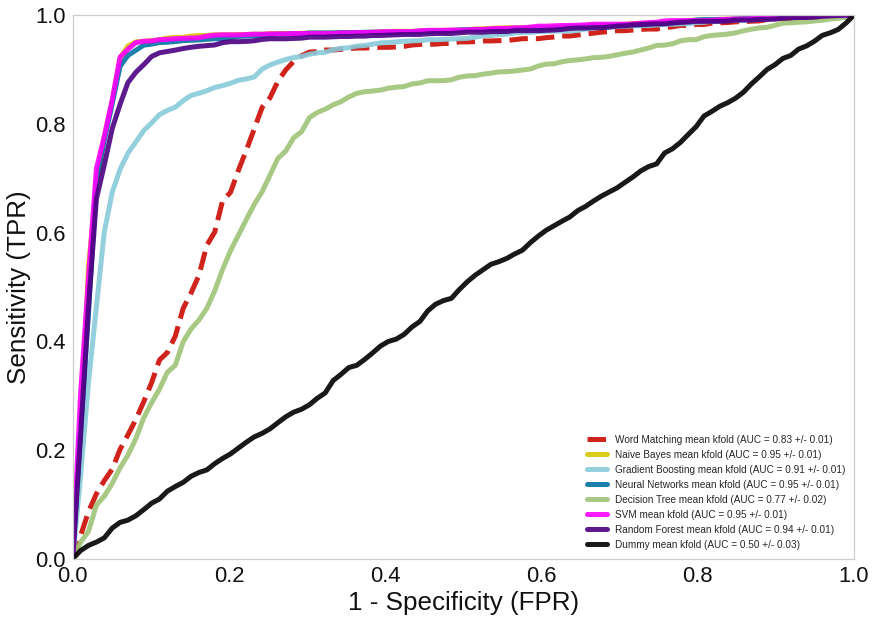

In [24]:
tm.setREF('Word Matching') # assign Word Matching as reference

plt = tm.plotROC()
plt.savefig('figures/results/ROC_curve_all_methods.png', bbox_inches='tight')

#### 4.1.1 Student's T-Test relative to Naive Word Matching
Evaluate the difference in performance by applying a t-test

- d_aucs = dictionary with all of the aucs 
- auc_ref = reference auc (in this case the auc of the Word Matching method is used)


In [25]:
d_aucs = tm.getAUC()
auc_ref = d_aucs['Word Matching']
auc_models = d_aucs


for key in d_aucs.keys(): # classifiers with probabilities
    twosample_results = tm.ttest_5x2cv(auc_models[key], auc_ref)
    print(key, '\t(p = ' + '{:.1e}'.format(twosample_results[1]) + ')')

Word Matching 	(p = 1.0e+00)
Naive Bayes 	(p = 2.3e-05)
Gradient Boosting 	(p = 2.0e-03)
Neural Networks 	(p = 1.6e-05)
Decision Tree 	(p = 4.6e-02)
SVM 	(p = 1.1e-05)
Random Forest 	(p = 5.9e-06)
Dummy 	(p = 1.3e-04)


### 4.2. AUC - Precision Recall curve

Word Matching mean kfold (AUPRC = 0.76 +/- 0.03)
Naive Bayes mean kfold (AUPRC = 0.94 +/- 0.01)
Gradient Boosting mean kfold (AUPRC = 0.89 +/- 0.02)
Neural Networks mean kfold (AUPRC = 0.94 +/- 0.01)
Decision Tree mean kfold (AUPRC = 0.72 +/- 0.03)
SVM mean kfold (AUPRC = 0.95 +/- 0.01)
Random Forest mean kfold (AUPRC = 0.93 +/- 0.01)
Dummy mean kfold (AUPRC = 0.51 +/- 0.03)


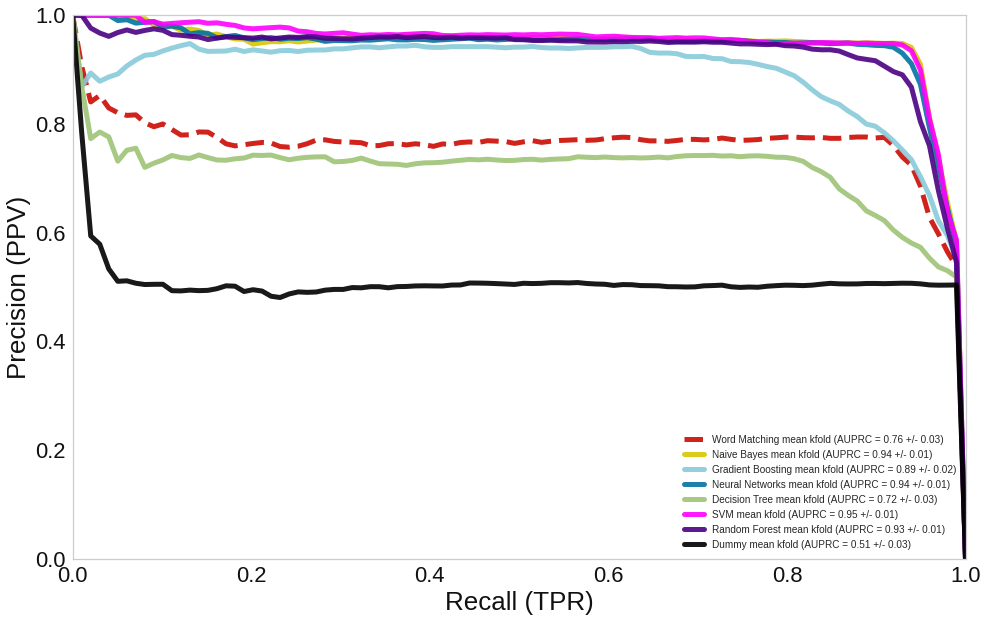

In [26]:
plt = tm.plotPrecisionRecall()
plt.savefig('figures/results/PR_curve_all_methods.png', bbox_inches='tight')

#### 4.2.2 Student's T-Test relative to Naive Word Matching (PR-AUC)

In [27]:
d_auprcs = tm.getAUPRC()
auprc_ref = d_auprcs['Word Matching']
auprc_models = d_auprcs

for key in d_aucs.keys(): # classifiers with probabilities
    twosample_results = tm.ttest_5x2cv(auprc_models[key], auprc_ref)
    print(key, '\t(p = ' + '{:.1e}'.format(twosample_results[1]) + ')')

Word Matching 	(p = 1.0e+00)
Naive Bayes 	(p = 4.4e-06)
Gradient Boosting 	(p = 2.9e-05)
Neural Networks 	(p = 5.2e-06)
Decision Tree 	(p = 5.3e-03)
SVM 	(p = 2.9e-06)
Random Forest 	(p = 2.3e-06)
Dummy 	(p = 8.1e-07)


### 4.3 F1-measures 
Valuable metric when dealing with data imbalance

Word Matching : 0.85+/-0.02
Naive Bayes : 0.95+/-0.01
Gradient Boosting : 0.86+/-0.01
Neural Networks : 0.94+/-0.01
Decision Tree : 0.79+/-0.02
SVM : 0.94+/-0.01
Random Forest : 0.92+/-0.01
Dummy : 0.67+/-0.02


<Figure size 1008x1008 with 0 Axes>

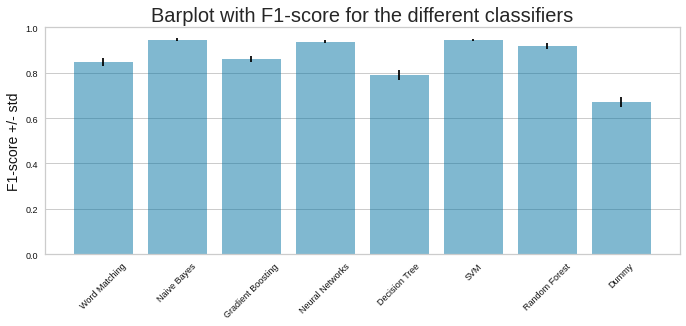

In [28]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':14, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)
plt = tm.plotF1scores(debug=True)

#### 4.3.2 Student's t-test on F1-scores
Only adviced if approach = 5x2 cv for a reliable outcome

In [29]:
d_f1 = tm.getF1()
f1_ref = d_f1['Word Matching']

for key in d_f1.keys(): # classifiers with probabilities
    twosample_results = tm.ttest_5x2cv(d_f1[key], f1_ref)
    print(key, '\t(p = ' + '{:.1e}'.format(twosample_results[1]) + ')')

Word Matching 	(p = 1.0e+00)
Naive Bayes 	(p = 3.2e-03)
Gradient Boosting 	(p = 9.3e-01)
Neural Networks 	(p = 2.5e-03)
Decision Tree 	(p = 2.6e-02)
SVM 	(p = 1.8e-03)
Random Forest 	(p = 7.7e-03)
Dummy 	(p = 6.2e-05)


## Step 5: Distribute Model - save classification model
With pickle you can save & load the models  
  
Prior to saving your model you can fit on the entire data, this is common practice. However, if it takes a long time to fit the model, then you can also choose to just take the median iteration of the specified classifier from the double CV

In [32]:
best_model = tm.getTrainedClassifier('SVM')
best_model.fit(tm.X, tm.y) # fit on entire data
filename='savedModels/SVM.sav'
pickle.dump(best_model, open(filename, 'wb'))

#### 5.1 Import trained classification model
Import the recently saved model (you can apply this model on a new unlabeled set)

In [33]:
filename='savedModels/SVM.sav'
loaded_model = pickle.load(open(filename, 'rb'))

## Step 6: Evaluate best Model
Visualize the prediction distribution (probabilities) of the classifier with a swarm plot. 

- You could also draw a scatterplot (by uncommenting the third line)

/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


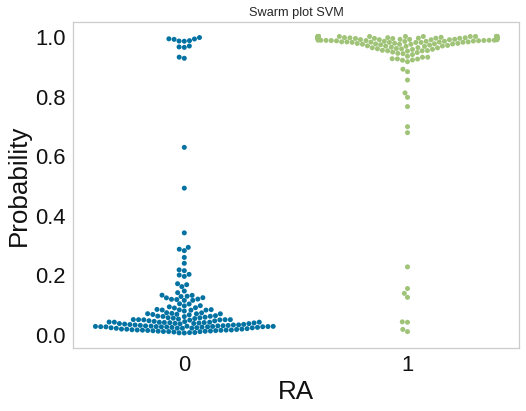

In [34]:
plt = tm.plotSwarm('SVM')
plt.savefig('figures/results/swarmplot_SVM.png', bbox_inches='tight')
# tm.plotScatter('SVM')

### 6.2 Define optimal cut-off
#### Example: Optimal threshold when Sensitivity of 0.9 is desired
Returns the threshold corresponding with a sensitivity (TPR in code) of 0.9 and the highest possible precision. Other options are : tpr, ppv and f1

Generating confusion matrix for SVM based on median Iteration (AUPRC):  4
Other weighing variables:  ['prc']
Thresh: 0.68 
PRC: 	0.93 
Sens: 	0.95 
Spec: 	0.93 
F1: 	0.94
NPV:	0.9487179487179487
ACC:	0.9401197604790419


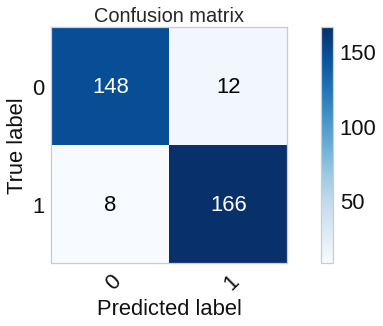

In [35]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm.getConfusionMatrix('SVM', desired=.9, most_val='tpr')

#### Example: Optimal cut-off when Precision of 0.9 is desired
Returns the threshold corresponding with a precision of 0.8 and the highest possible sensitivity

Generating confusion matrix for SVM based on median Iteration (AUPRC):  4
Other weighing variables:  ['tpr']
Thresh: 0.68 
PRC: 	0.93 
Sens: 	0.95 
Spec: 	0.93 
F1: 	0.94
NPV:	0.9487179487179487
ACC:	0.9401197604790419


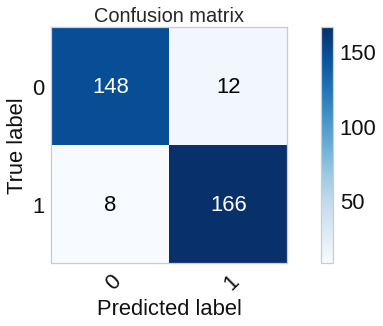

In [36]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm.getConfusionMatrix('SVM', desired=0.9, most_val='prc')

### [Extra analysis] 6.3 Effect of prevalence on Precision Recall 
Applying a trainingsset with a different prevalence every time 

In [298]:
params = {'figure.figsize': (8,6), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

plt, d_aucs = tm.plotPrevalencePR('SVM', cv=False)

### [Extra analysis] 6.4 Effect of sample size
Gradually increase the sample size of the trainingsset with a predefined stepsize. Furthermore, you could also choose to apply cross validation (cv) for more robust measurements.
#### ROC

In [299]:
plt, d_aucs = tm.samplingCurveROC('SVM', stepsize=100 , cv=True)

#### Precision Recall

In [300]:
plt, d_aucs = tm.samplingCurvePR('SVM', stepsize=100 , cv=True)

### 6.5 Most important features

#### SVM

In [38]:
tm.plot_coefficients('SVM', top_features=10, chunks=3, negative=False)

# Step 7: Employ model on independent test set
Apply classifier on independent test set for an unbiased evaluation

- toDO: plot confusion matrix with corresponding metrics with cut-off (Ppv, npv, sens, spec, f1, accuracy)
- plot pr AUC & roc AUC

## 7.1 load & prepare test set
### Import test data & final model

In [39]:
file_name='sample_data/dummydata_gold.csv'
model_name='savedModels/SVM.sav'

valid_df = pd.read_csv(file_name, sep=';')
loaded_model = pickle.load(open(model_name, 'rb'))
valid_df.head()

,PATNR,annotation,text
0,51.0,True,w folaatzuur mg w prednison mg afspraak w acti...
1,219.0,False,spronggewricht echter geen artritis objectivee...
2,230.0,False,in verleden minimaal calciumintaak geen osteop...
3,58.0,True,van depomedrol ct bdz bij verdenking quervain ...
4,288.0,True,reeds gestarren suppletie via huisarts doormaa...


### Define relevant columns:
- X column = text column
- y column = label to predict (if available) -> otherwise you can provide an empty string
- id column = patient id

In [40]:
id_column='PATNR'
X_column='text'
y_column="annotation"

### Prepare test data

In [42]:
print('[BEFORE] nr of entries:', len(radiag_df), '\tnr of patients:', len(radiag_df['PATNR'].unique()))
valid_df = func.mergeOnColumn(valid_df, id_column, X_column, y_column)
print('[AFTER] nr of entries:', len(radiag_df), '\tnr of patients:', len(radiag_df['PATNR'].unique()))

valid_df[X_column] = valid_df[X_column].apply(lambda x : func.processArtefactsXML(str(x)))
valid_df[X_column] = valid_df[X_column].apply(lambda x : func.simpleCleaning(x, lemma=False))
valid_df[X_column] = valid_df[X_column].apply(lambda x : func.stemmingText(x, stemmer=stemmer)) 
valid_df = valid_df.fillna('')
valid_df.to_csv(r'validation/prepped_gold_df.csv', sep='|', index=False)

[BEFORE] nr of entries: 668 	nr of patients: 668
[AFTER] nr of entries: 668 	nr of patients: 668


## 7.2 Make predictions

In [44]:
import pickle

# get EMR text
valid_X = valid_df[X_column].values

# apply built model on provided text
probas_ = loaded_model.predict_proba(valid_X)
pred = probas_[:,1]

# add predictions to table & save predictions
valid_df['prediction'] = valid_df['PATNR'].copy()
valid_df['prediction'] = pred
valid_df.to_csv(r'validation/gold_predictions.csv', sep='|', index=False)

valid_df.head()

,text,PATNR,annotation,prediction
0,w folaatzur mg w prednison mg afsprak w acti...,51.0,True,0.870694
1,spronggewricht echter gen artritis objective...,219.0,False,0.040848
2,in verled minimal calciumintak gen osteoporo...,230.0,False,0.080816
3,van depomedrol ct bdz bij verdenk quervain t...,58.0,True,0.953309
4,red gestarr suppletie via huisart doormak ne...,288.0,True,0.030657


## 7.3 Evaluate the model
You can evaluate the model if you have annotated the test set.
#### Draw ROC curve
Assess the performance of the model on the gold standard EHR-set by comparing the predictions of the model to the annotation (y_column)

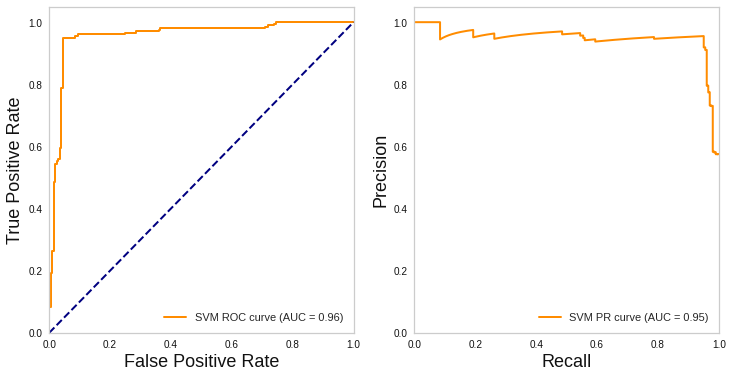

In [45]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, _ = roc_curve(valid_df[y_column], valid_df['prediction'])
prec, recall, _ = precision_recall_curve(valid_df[y_column], valid_df['prediction'])

pr_auc = auc(recall, prec)
roc_auc = auc(fpr, tpr)

fig1, ax1 = plt.subplots(1,2,figsize=(12,6))

clf_name = re.match(r'.*/(.*).sav', model_name).group(1)

lw = 2
## ROC
ax1[0].plot(fpr, tpr, color='darkorange',
         lw=lw, label='%s ROC curve (AUC = %0.2f)' % (clf_name, roc_auc))
ax1[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1[0].set_xlim([0.0, 1.0])
ax1[0].set_ylim([0.0, 1.05])
ax1[0].set_xlabel('False Positive Rate', fontsize=18)
ax1[0].set_ylabel('True Positive Rate', fontsize=18)
ax1[0].legend(loc="lower right", fontsize=11)
ax1[0].tick_params(axis='both', which='major', labelsize=10)
ax1[0].tick_params(axis='both', which='minor', labelsize=8)

## PR
ax1[1].plot(recall, prec, color='darkorange',
         lw=lw, label='%s PR curve (AUC = %0.2f)' % (clf_name, pr_auc))
ax1[1].set_xlim([0.0, 1.0])
ax1[1].set_ylim([0.0, 1.05])
ax1[1].set_xlabel('Recall', fontsize=18)
ax1[1].set_ylabel('Precision', fontsize=18)
ax1[1].legend(loc="lower right", fontsize=11)
ax1[1].tick_params(axis='both', which='major', labelsize=10)
ax1[1].tick_params(axis='both', which='minor', labelsize=8)

plt.show()

## 7.4 Apply cut-off
Visualize the corresponding confusion matrix & assess whether the classifier is able to maintain a similarly high precision/ sensitivity in the test set.

In [ ]:
import importlib as imp
cut_off = 0.68 # defined on the trainingsset

tm.classificationReport(valid_df[y_column], valid_df['prediction'], threshold=0.68)

## Extra: (Step 8) Visualize most important features 
Optional Visualizations 

Keep in mind: feature importance is not currently working -> so the examples below are general visualizations


### 8.1 Pearson correlation per feature

/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


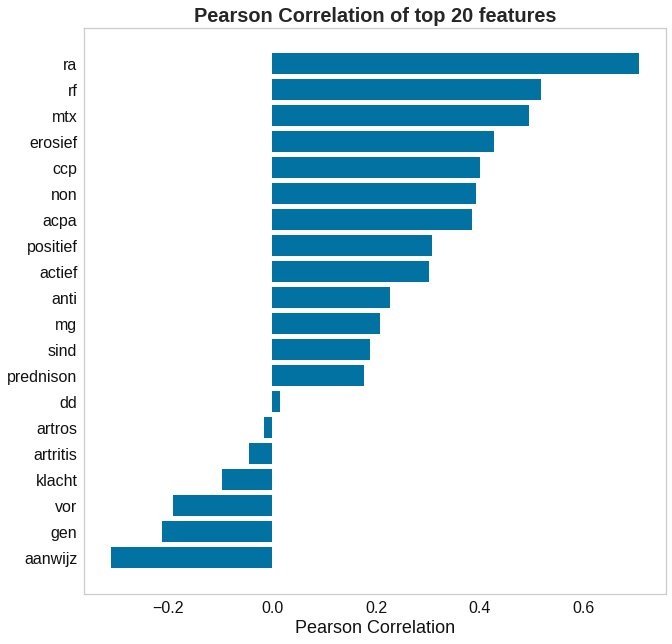

In [47]:
clf, pred, x_train, y_train = tm.getTrainedClassifier('SVM', clf=False)
plt = func.plotFeatureCorrelation(x_train, y_train, nr_features=20, ngram_range=(1,3))
locs, labels = plt.yticks()  

plt.show()

### 8.2 Is the training set representable for the test set
Should be comparable -> otherwise you dont have a representable train/test set

##### Input:
- nr_features = number of features to draw in the distribution plot

##### Disclaimer
In this case both distributions are almost exactly the same: this almost never happens with real data (we used dummy data). 
You should be skeptical if the datasets align perfectly.

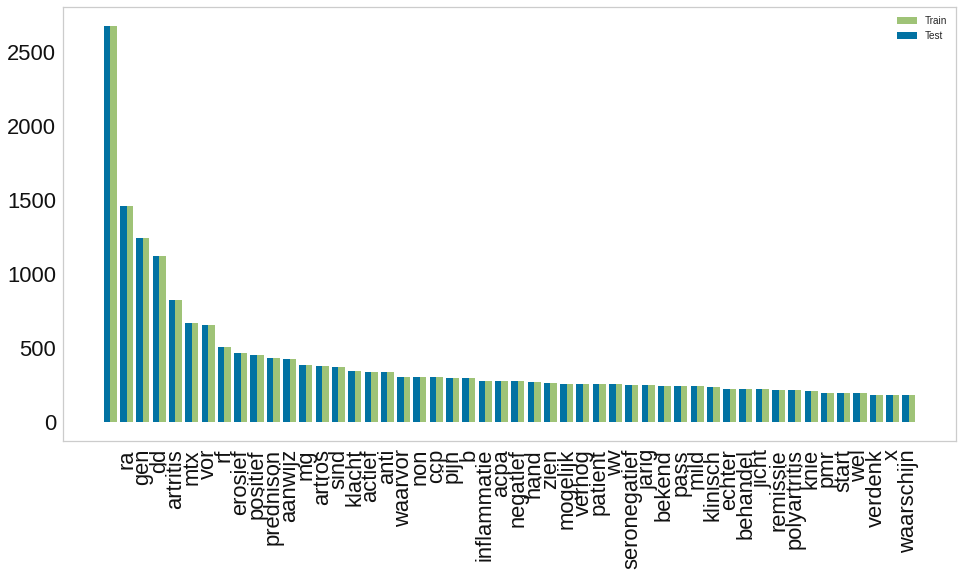

In [48]:
import matplotlib.pyplot as plt

# remove stop words in test set
radiag_df['Text'] = radiag_df['Text'].apply(lambda x: ' '.join([item for item in x.split(' ') if item not in stop_words]))
valid_X = radiag_df['Text']

# Assess most prevalent features
func.plotTrainTestDistribution(X, valid_X, nr_features=50) 